In [33]:
import cv2
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [34]:
PTS_IMAGE_PLANE = [[483, 210],
                   [244, 206],
                   [173, 249],
                   [584, 286]]

PTS_GROUND_PLANE = [[39, -13],
                    [39, 13],
                    [23, 13],
                    [23, -13]]

METERS_PER_INCH = 0.0254

def transformUvToXy(self, u, v):
    """
    u and v are pixel coordinates.
    The top left pixel is the origin, u axis increases to right, and v axis
    increases down.

    Returns a normal non-np 1x2 matrix of xy displacement vector from the
    camera to the point on the ground plane.
    Camera points along positive x axis and y axis increases to the left of
    the camera.

    Units are in meters.
    """
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(self.h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    x = homogeneous_xy[0, 0]
    y = homogeneous_xy[1, 0]
    return x, y


In [35]:
image = cv2.imread("racetrack_images/lane_1/image2.png")
if image is None:
    raise IOError("Could not read the image.")

# Convert to HSV for better color segmentation of white
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 2. Threshold for white color
# lower_white = np.array([0, 0, 100])  # Further lowered value threshold to detect even darker whites
# upper_white = np.array([180, 100, 255])  # Increased saturation threshold to allow more variation

lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])

mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)

roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Apply ROI mask to the thresholded image
roi_result = cv2.bitwise_and(mask, roi_mask)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

# 4. Edge Detection & Hough Transform
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()

# Compute homography matrix
h, _ = cv2.findHomography(PTS_IMAGE_PLANE, PTS_GROUND_PLANE)
def transform_point(u, v, h):
    """Transform a single point from image to ground plane coordinates"""
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    return homogeneous_xy[0, 0], homogeneous_xy[1, 0]

# After detecting lines with Hough transform, transform each line and filter by angle
ground_lines = []
filtered_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Transform start and end points of each line
        x1_g, y1_g = transform_point(x1, y1, h)
        x2_g, y2_g = transform_point(x2, y2, h)
        
        # Calculate angle with x-axis in degrees
        angle = np.degrees(np.arctan2(y2_g - y1_g, x2_g - x1_g))
        # Normalize angle to 0-180
        angle = abs(angle) if angle >= 0 else abs(180 + angle)
        
        # Filter lines: keep only those roughly parallel or perpendicular to x-axis
        # Allow for some deviation (±15 degrees) from 0°, 90°, or 180°
        if (angle < 15 or (75 < angle < 105) or angle > 165):
            ground_lines.append((x1_g, y1_g, x2_g, y2_g))
            filtered_lines.append(line)
            # Draw the filtered line
            cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
            # Add text label
            cv2.putText(line_image, f"{angle:.1f}°", (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# Plot ROI
ax1.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()
ax1.set_title('Region of Interest')

# Plot detected lines
ax2.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
ax2.set_axis_off()
ax2.set_title('Filtered Lines')

# Plot top-down view in third subplot
ax3.grid(True)

# Plot the ground plane points used for homography (for reference)
pts_ground = np.array(PTS_GROUND_PLANE)
ax3.scatter(pts_ground[:, 0], pts_ground[:, 1], c='red', label='Reference Points')

# Plot transformed lines
for x1_g, y1_g, x2_g, y2_g in ground_lines:
    ax3.plot([x1_g, x2_g], [y1_g, y2_g], 'g-', alpha=0.5)

# Set equal aspect ratio for proper visualization
ax3.set_aspect('equal')
ax3.set_xlabel('X (meters)')
ax3.set_ylabel('Y (meters)')
ax3.set_title('Top-down View')
ax3.legend()

# Add coordinate system origin
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax3.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Set reasonable axis limits based on the reference points
margin = 2  # meters
ax3.set_xlim(min(pts_ground[:, 0]) - margin, max(pts_ground[:, 0]) + margin)
ax3.set_ylim(min(pts_ground[:, 1]) - margin, max(pts_ground[:, 1]) + margin)

plt.tight_layout()
plt.show()


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'findHomography'
> Overload resolution failed:
>  - srcPoints is not a numpy array, neither a scalar
>  - findHomography() missing required argument 'params' (pos 3)
>  - Expected Ptr<cv::UMat> for argument 'srcPoints'
>  - findHomography() missing required argument 'params' (pos 3)


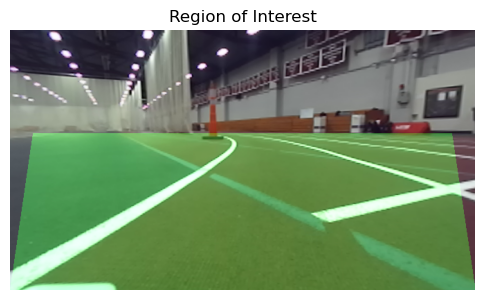

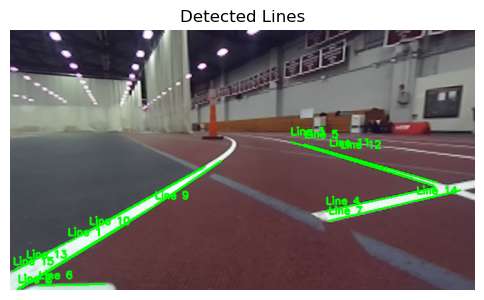

In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


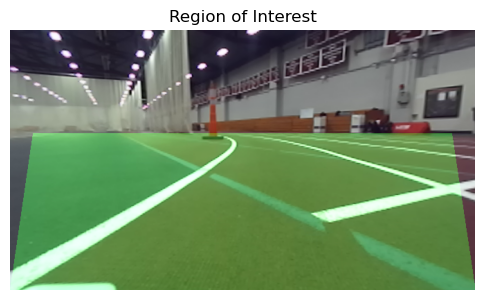

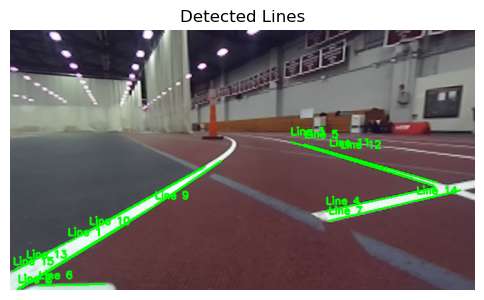

In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


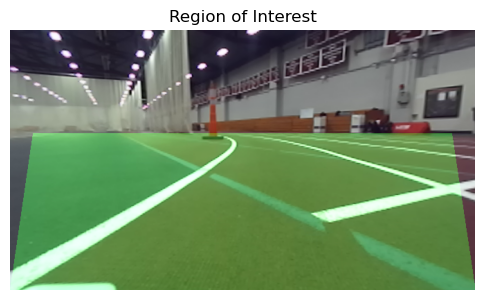

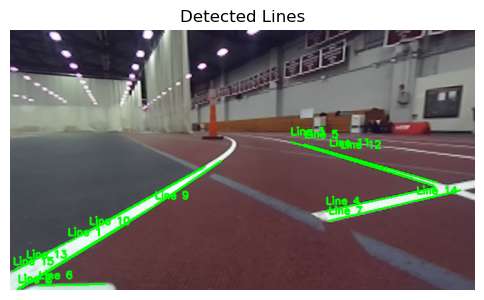

In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


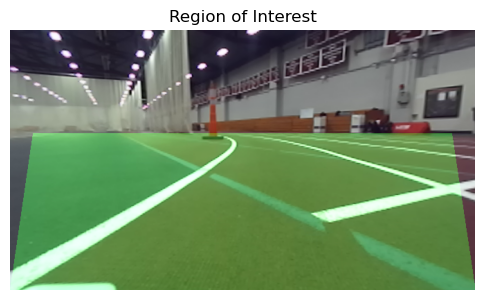

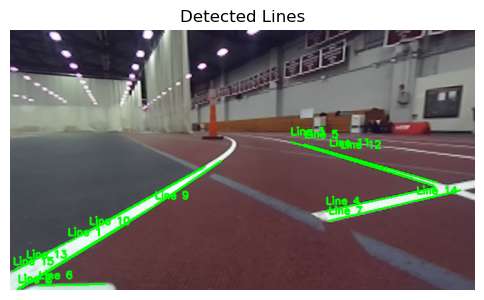

In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


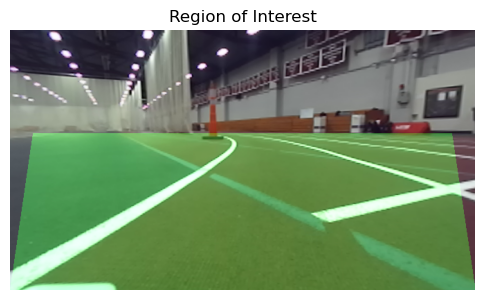

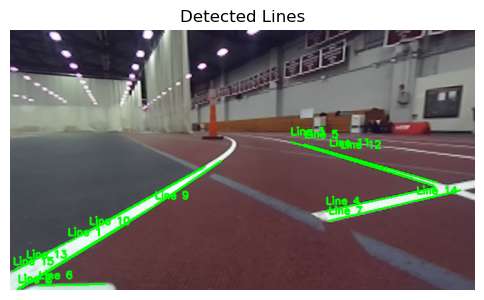

In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


In [ ]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


NameError: name 'hsv' is not defined

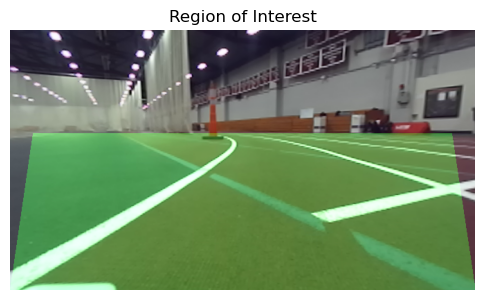

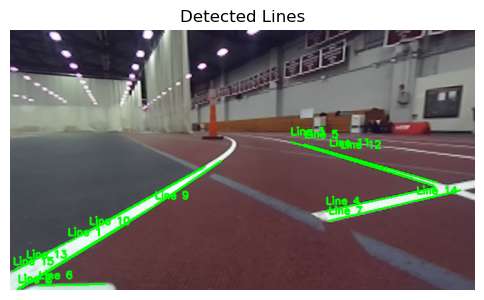

In [12]:
# 2. Threshold for white color
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

# 3. Define a Region of Interest (ROI)
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)

plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Region of Interest')
plt.show()

# Apply the ROI to the mask
roi_result = cv2.bitwise_and(mask, mask, mask=roi_mask)

# -------------------------------
# 4. Edge Detection & Hough Transform
# -------------------------------
# Use Canny edge detection on the ROI result.
edges = cv2.Canny(roi_result, 50, 150)

# Use Probabilistic Hough Transform to detect line segments.
lines = cv2.HoughLinesP(edges, 
                        rho=1, 
                        theta=np.pi / 180, 
                        threshold=50, 
                        minLineLength=50, 
                        maxLineGap=10)

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.figure(figsize=(6,4))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Lines')
plt.show()


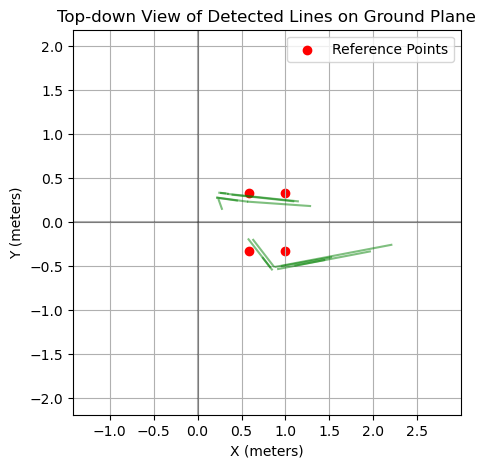

In [13]:

# First compute the homography matrix using the provided correspondences
PTS_IMAGE_PLANE = np.array([[483, 210],
                           [244, 206],
                           [173, 249],
                           [584, 286]], dtype=np.float32)

PTS_GROUND_PLANE = np.array([[39, -13],
                            [39, 13],
                            [23, 13],
                            [23, -13]], dtype=np.float32) * METERS_PER_INCH

# Compute homography matrix
h, _ = cv2.findHomography(PTS_IMAGE_PLANE, PTS_GROUND_PLANE)

def transform_point(u, v, h):
    """Transform a single point from image to ground plane coordinates"""
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    return homogeneous_xy[0, 0], homogeneous_xy[1, 0]

# After detecting lines with Hough transform, transform each line to ground coordinates
ground_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Transform start and end points of each line
        x1_g, y1_g = transform_point(x1, y1, h)
        x2_g, y2_g = transform_point(x2, y2, h)
        ground_lines.append((x1_g, y1_g, x2_g, y2_g))

# Plot top-down view
plt.figure(figsize=(5, 5))
plt.grid(True)

# Plot the ground plane points used for homography (for reference)
pts_ground = PTS_GROUND_PLANE
plt.scatter(pts_ground[:, 0], pts_ground[:, 1], c='red', label='Reference Points')

# Plot transformed lines
for x1_g, y1_g, x2_g, y2_g in ground_lines:
    plt.plot([x1_g, x2_g], [y1_g, y2_g], 'g-', alpha=0.5)

# Set equal aspect ratio for proper visualization
plt.axis('equal')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Top-down View of Detected Lines on Ground Plane')
plt.legend()

# Add coordinate system origin
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Set reasonable axis limits based on the reference points
margin = 2  # meters
plt.xlim(min(pts_ground[:, 0]) - margin, max(pts_ground[:, 0]) + margin)
plt.ylim(min(pts_ground[:, 1]) - margin, max(pts_ground[:, 1]) + margin)

plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


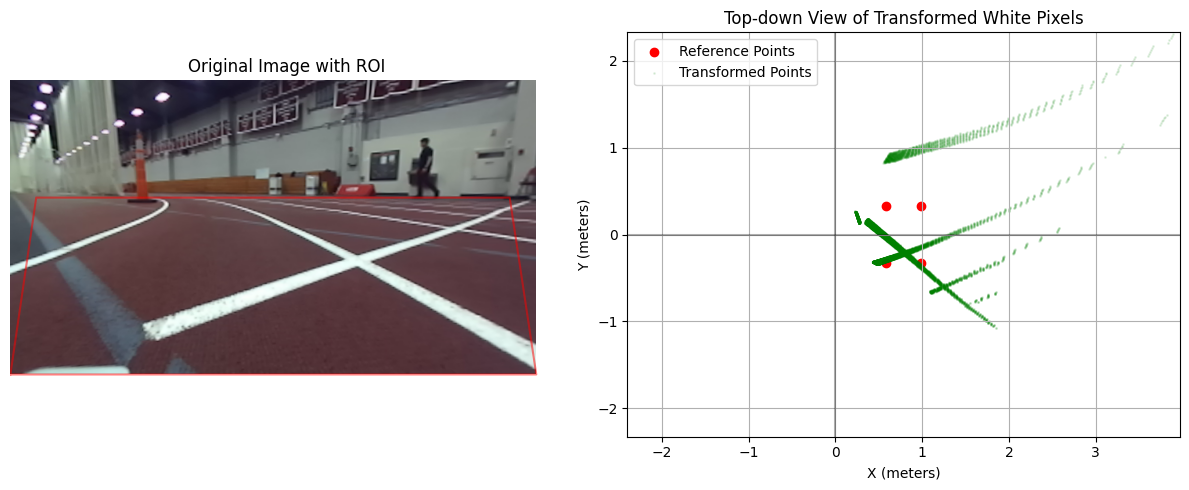

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# First compute the homography matrix using the provided correspondences
PTS_IMAGE_PLANE = np.array([[483, 210],
                           [244, 206],
                           [173, 249],
                           [584, 286]], dtype=np.float32)

PTS_GROUND_PLANE = np.array([[39, -13],
                            [39, 13],
                            [23, 13],
                            [23, -13]], dtype=np.float32) * METERS_PER_INCH

# Compute homography matrix
h, _ = cv2.findHomography(PTS_IMAGE_PLANE, PTS_GROUND_PLANE)
image = cv2.imread("racetrack_images/lane_1/image8.png")
if image is None:
    raise IOError("Could not read the image.")

mask = np.zeros_like(image[:,:,0])
height, width = mask.shape
roi_mask = np.zeros_like(mask)
# For a nearly rectangular trapezoid ROI
roi_corners = np.array([[(0, height),
                        (width, height),
                        (int(width * 0.95), int(height * 0.4)),  # Changed from 0.6 to 0.4
                        (int(width * 0.05), int(height * 0.4))]])  # Changed from 0.6 to 0.4

cv2.fillPoly(roi_mask, roi_corners, 255)

def transform_point(u, v, h):
    """Transform a single point from image to ground plane coordinates"""
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    return homogeneous_xy[0, 0], homogeneous_xy[1, 0]

# First threshold the image to get white pixels
_, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

# Apply ROI mask to binary image
binary_masked = cv2.bitwise_and(binary[:,:,0], roi_mask)

# Get coordinates of white pixels within ROI
white_pixels = np.where(binary_masked > 0)
ground_points = []

# Transform each white pixel to ground coordinates
for y, x in zip(white_pixels[0], white_pixels[1]):
    x_g, y_g = transform_point(x, y, h)
    ground_points.append([x_g, y_g])

ground_points = np.array(ground_points)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot 1: Original image with ROI
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# Draw ROI polygon
roi_display = roi_corners.reshape((-1, 2))
plt.plot(roi_display[[0,1,2,3,0], 0], roi_display[[0,1,2,3,0], 1], 'r-', alpha=0.5)
plt.title('Original Image with ROI')
plt.axis('off')

# Plot 2: Top-down transformed view
plt.subplot(1, 2, 2)
plt.grid(True)

# Plot the ground plane points used for homography
pts_ground = PTS_GROUND_PLANE
plt.scatter(pts_ground[:, 0], pts_ground[:, 1], c='red', label='Reference Points')

# Plot transformed points
if len(ground_points) > 0:
    plt.scatter(ground_points[:, 0], ground_points[:, 1], c='green', s=1, alpha=0.1, label='Transformed Points')

plt.axis('equal')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Top-down View of Transformed White Pixels')
plt.legend()

# Add coordinate system origin
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Set reasonable axis limits
margin = 2  # meters
plt.xlim(min(pts_ground[:, 0]) - margin, max(pts_ground[:, 0]) + margin)
plt.ylim(min(pts_ground[:, 1]) - margin, max(pts_ground[:, 1]) + margin)

plt.tight_layout()
plt.show()


In [ ]:

# # -------------------------------
# # 5. Filter lines by Orientation (nearly vertical) and select the candidate
# # -------------------------------
# main_track_lines = []

# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         # Calculate the angle in degrees.
#         angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))

#         # Filter by angle and minimum length
#         if abs(angle) > 10:  # Minimum length threshold of 100 pixels
#             main_track_lines.append((x1, y1, x2, y2))

# # Display filtered lines
# filtered_line_image = image.copy()
# for x1, y1, x2, y2 in main_track_lines:
#     cv2.line(filtered_line_image, (x1,y1), (x2,y2), (0,255,0), 2)

# plt.figure(figsize=(6,4))
# plt.imshow(cv2.cvtColor(filtered_line_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.title('Filtered Long Vertical Lines')
# plt.show()



# # If multiple candidate lines are detected, choose the one that is "most central"
# # near the bottom center of the image.
# selected_line = None
# if main_track_lines:
#     center_x = width / 2
#     best_score = float("inf")
#     for (x1, y1, x2, y2) in main_track_lines:
#         # Compute the midpoint of the line segment.
#         mid_x = (x1 + x2) / 2
#         mid_y = (y1 + y2) / 2
#         # Compute the Euclidean distance from the midpoint to the bottom-center.
#         dist = np.sqrt((mid_x - center_x) ** 2 + (mid_y - height) ** 2)
#         # Optionally, consider line length. A longer line is typically a better candidate.
#         length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
#         # Define a score where lower is better. This score penalizes high distance and favors longer lines.
#         score = dist - 0.5 * length  # Weight parameter (0.5) may require tuning.
#         if score < best_score:
#             best_score = score
#             selected_line = (x1, y1, x2, y2)

# # -------------------------------
# # 6. Visualization of the selected main track line
# # -------------------------------
# output_image = image.copy()
# if selected_line is not None:
#     x1, y1, x2, y2 = selected_line
#     cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
#     cv2.putText(output_image, "Main Track", (x1, y1 - 10),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
# else:
#     cv2.putText(output_image, "No main track detected", (10, 30),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# plt.figure(figsize=(10,4))

# plt.subplot(131)
# plt.imshow(cv2.cvtColor(roi_result, cv2.COLOR_BGR2RGB))
# plt.title("ROI")
# plt.axis('off')

# plt.subplot(132)
# plt.imshow(edges, cmap='gray')
# plt.title("Edges") 
# plt.axis('off')

# plt.subplot(133)
# plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
# plt.title("Selected Main Track")
# plt.axis('off')

# plt.tight_layout()
# plt.show()
